### Trying to encode chaos into images
Pretty basic for now


In [1]:
from pytisean import tiseano, tiseanio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from scipy import integrate

import seaborn as sns
import matplotlib.image as mpimg

from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
import matplotlib.animation as animation

from matplotlib.animation import FFMpegWriter

%matplotlib inline

#### First we read in an image and generate a chaotic attractor
Here we had the idea to cheat initially and just create two chaotic series, with slightly offset time intervals.

### This is the meaty bit
where we take a subset of the training image and do the mapping from one series to another. It takes a minute or so to run given the matching algorithm is pretty unoptimized.

### Conduct image row by row permutations

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

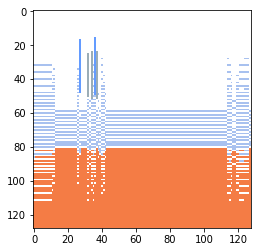

In [3]:
angle=0.0 
max_time=30.0
sigma=10.0 
beta=4./3 
rho=28.0
x0_0 = x0 = -15 + 30 * np.array([[  0.02,   0.01,   0.002]])

def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

def lorenz_integrate(x0, max_time, numSteps):
    t = np.linspace(0, max_time, int(numSteps*max_time))
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
        for x0i in x0])
    x, y, z = x_t[0,:,:].T
    return x, y, z
    
def forwardLorenz(x, y, z, start, pert_mult, max_time, numSteps):
    pert = random.random() * pert_mult
    x0_n = [[x[start]+pert, y[start]+pert, z[start]+pert]]
    x, y, z = lorenz_integrate(x0_n, max_time, numSteps)
    return x, y, z

def importImage(image_name):
    img = mpimg.imread(image_name)
    return img


img = importImage('demo.png')
newImg = np.empty_like(img)
x_0, y_0, z_0 = lorenz_integrate(x0_0, 150, 60)

writer = FFMpegWriter(fps=15)
fig = plt.figure()
with writer.saving(fig, "imgTest.mp4", 100):
    for i in range(100):
        img = importImage('demo.png')

        x_n, y_n, z_n = forwardLorenz(x_0, y_0, z_0, i, 10**(-2), 150, 60)
        print(i)
        for band in [0,1,2]:
            for row in np.arange(len(img)):
                for time in np.arange(1,len(img)): 
                        thisRow = img[row,:,band]
                        x1 = x_0[time]
                        xdif = np.abs(x_n[:len(img)] - x1)
                        sortedDif = np.sort(xdif)
                        variation = sortedDif[0]
                        img[row,time,band] = thisRow[np.where(xdif==variation)[0]]

        plt.imshow(img)
        writer.grab_frame()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

IndexError: index 900 is out of bounds for axis 0 with size 900

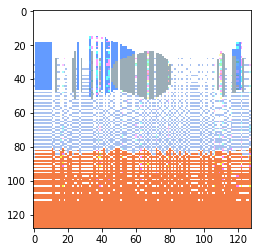

In [12]:
img = importImage('demo.png')
newImg = np.empty_like(img)
x_0, y_0, z_0 = lorenz_integrate(x0_0, 15, 60)

writer = FFMpegWriter(fps=15)
fig = plt.figure()
with writer.saving(fig, "imgTest_2.mp4", 100):
    for i in range(1000):
        img = importImage('demo.png')

        print(i)
        for band in [0,1,2]:
            for row in np.arange(len(img)):
                x_n, y_n, z_n = forwardLorenz(x_0, y_0, z_0, 20+i, 10**(-2), 15, 60)

                for time in np.arange(1,len(img)): 
                        thisRow = img[row,:,band]
                        x1 = x_0[time]
                        xdif = np.abs(x_n[:len(img)] - x1)
                        sortedDif = np.sort(xdif)
                        variation = sortedDif[0]
                        img[row,time,band] = thisRow[np.where(xdif==variation)[0]]

        plt.imshow(img)
        writer.grab_frame()


### Now that the remapping is finshed
we can take a look at the output. We can also run the reshaping in reverse to make sure the garbled output is happening correctly. Its a mess, but its a start.

Next steps are to advance the series properly using an ODE and integrate from slightly different initial conditions. Also, given the series starts to diverge the longer it runs, we can try and do this image noise introduction one line at a time.

In [56]:
thisBand

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       ..., 
       [ 0.95686275,  0.95686275,  0.95686275, ...,  0.95686275,
         0.95686275,  0.95686275],
       [ 0.95686275,  0.95686275,  0.95686275, ...,  0.95686275,
         0.95686275,  0.95686275],
       [ 0.95686275,  0.95686275,  0.95686275, ...,  0.95686275,
         0.95686275,  0.95686275]], dtype=float32)

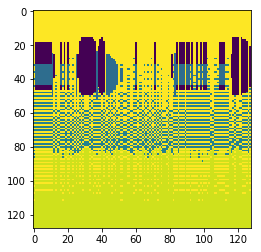

In [57]:
plt.imshow(thisBand.reshape(128,128))

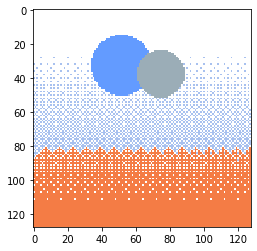

In [116]:
img = mpimg.imread('demo.png')
plt.imshow(img)

### The x-values start to get crazy over time
This makes sense, if we were only using the say first 500 values, we would be in better shape. The line by line idea may help a lot.

### Here'e the full image and some code to cut it up into its colors

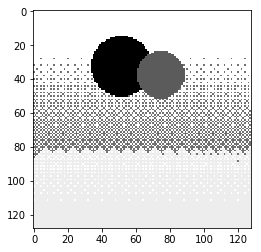

In [70]:
img = mpimg.imread('demo.png')
plt.imshow(img)
numPixels = np.size(img[:,:,0].ravel())
plt.imshow(img[:,:,0], cmap = 'gray')
imgMap = pd.DataFrame(dict(Time = np.arange(0,numPixels), 
                  R = img[:,:,0].ravel(), 
                  G = img[:,:,1].ravel(), 
                  B = img[:,:,2].ravel(),
                  A = img[:,:,3].ravel()))

#pd.concat([LDF, imgMap])
imgMap.index = imgMap.Time
L2.index = L2.Time

#imgMap = imgMap.append(imgMap)
#wrapped = pd.concat([LDF,imgMap], axis = 1, ignore_index=True)


In [16]:
wrapped.columns = ['CAidx','x','y','z','A','R','G','B','IMGidx']
wrapped.head()

,CAidx,x,y,z,A,R,G,B,IMGidx
Time,,,,,,,,,
0,0,-3.454,-2.268,23.393,1.0,1.0,1.0,1.0,0.0
1,1,-3.348,-2.411,22.856,1.0,1.0,1.0,1.0,1.0
2,2,-3.266,-2.564,22.336,1.0,1.0,1.0,1.0,2.0
3,3,-3.207,-2.729,21.832,1.0,1.0,1.0,1.0,3.0
4,4,-3.170,-2.906,21.346,1.0,1.0,1.0,1.0,4.0
